<a href="https://colab.research.google.com/github/NehaKumari500092077/Deep-Learning-Lab/blob/main/Programming%20Assignment%208%20Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get all the imports

In [ ]:
import pandas as pd
import numpy as np
import torch
torch.manual_seed(27)
import random
random.seed(27)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
from copy import deepcopy
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import nltk
from nltk.corpus import stopwords
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Define the text pre-processing pipeline

In [ ]:
# Pre-process text by removing stopwords, punctuations, adding special tokens
# and setting all samples to the same length for efficient batching of data
def text_preprocess_pipeline(text_list, max_len=32):
    # Get the stopwords
    stop_words = set(stopwords.words('english'))
    text_list_processed = list()
    for text in tqdm(text_list, desc="Pre-processing Data"):
        # Convert to lowercase and remove leading and trailing spaces
        text = text.lower().strip()
        # Tokenize the text
        tokens = word_tokenize(text)
        # Remove stopwords and punctuations
        cleaned_tokens = [token for token in tokens if (token not in stop_words and token.isalpha())]
        # Chop text size to max length
        cleaned_tokens = cleaned_tokens[:max_len-1]
        # Append special token to denote end of sentence
        cleaned_tokens.append("<eos>")
        # Append <pad> token if required to achieve fixed length for each sample
        if len(cleaned_tokens) < max_len:
            cleaned_tokens+= ["<pad>" for i in range(max_len-len(cleaned_tokens))]
        # Finally save the cleaned text
        text_list_processed.append(cleaned_tokens)
    return text_list_processed

## Define a function to generate a vocabulary and convert tokens to ids

In [ ]:
# Generate vocabulary and convert text to ids
def convert_text_to_idx(text_list_tokenized, create_vocab=True, token_to_idx=None):
    # This will save all the ids corresponding to each token
    if create_vocab:
        token_to_idx = {"<pad>": 0, "<eos>": 1, "<unk>": 2}
        # This will save all tokens corresponding to each id
        idx_to_token = dict([[value, key] for key, value in token_to_idx.items()])
        # This counter determines the id for each token
        idx_counter = 3
    # This will save the frequency of each token
    token_freq = dict([[key, 0] for key in token_to_idx.keys()])
    # All tokenized sentences converted to ids will be saved here
    text_list_converted = list()

    # Generate the vocab and convert to ids
    for text_tokenized in tqdm(text_list_tokenized, desc="Generating vocab and converting to ids"):
        tokens_as_ids = list()
        for token in text_tokenized:
            if token not in token_to_idx:
                # If token does not exist in vocab and we have to generate the vocab
                # Then add it to the vocab and assign a unique id
                if create_vocab:
                    token_to_idx[token] = idx_counter
                    idx_to_token[idx_counter] = token
                    token_freq[token] = 1
                    idx_counter+=1
                # If token does not exist in vocab and we are not creating the vocab
                # Then assign the special token <unk>
                else:
                    token = "<unk>"
                    token_freq[token]+=1
            # If token exists in vocab then increase its frequency
            else:
                token_freq[token]+=1
            tokens_as_ids.append(token_to_idx[token])
        text_list_converted.append(tokens_as_ids)
    # Return the list and all three dictionaries
    if create_vocab:
        return text_list_converted, token_to_idx, idx_to_token, token_freq
    else:
        return text_list_converted, token_freq

## Load the data, pre-process and split into train and validation

In [ ]:
num_classes = 20
seq_len = 150

train = fetch_20newsgroups(subset='train')
test = fetch_20newsgroups(subset='test')

# Pre-process the data
X = text_preprocess_pipeline(train.data, seq_len)
# Now Split the data into train and val
X_train, X_val, Y_train, Y_val = train_test_split(X, train.target, test_size=0.2, random_state=27, stratify=train.target)
print("\nThe first tokenized sentence in the train set\n", X_train[0], "\n The total number of samples in train set", len(X_train))
print("\nThe first tokenized sentence in the validation set\n", X_val[0], "\n The total number of samples in validation set", len(X_val), "\n\n")
# Convert text to ids
X_train, token_to_idx, idx_to_token, token_freq_train = convert_text_to_idx(X_train, create_vocab=True, token_to_idx=None)
X_val, token_freq_val = convert_text_to_idx(X_val, create_vocab=False, token_to_idx=token_to_idx)
print("\nThe first id based sentence in the train set\n", X_train[0])
print("\nThe first id based sentence in the validation set\n", X_val[0], "\n\n")
# Check out the top 10 tokens in each set
token_freq_train = Counter(token_freq_train)
print("\n\n\nTop 10 most frequent tokens in the Train set:\n", token_freq_train.most_common(10))
token_freq_val = Counter(token_freq_val)
print("\n\nTop 10 most frequent tokens in the Validation set:\n", token_freq_val.most_common(10))

# Do the same for test data as well
# Pre-process the data
X = text_preprocess_pipeline(test.data, seq_len)
# Convert text to ids
X_test, token_freq_test = convert_text_to_idx(X, create_vocab=False, token_to_idx=token_to_idx)
Y_test = test.target
print("\nThe first id based sentence in the test set\n", X_test[0])
# Check out the most common words
token_freq_test = Counter(token_freq_test)
print("\n\nTop 10 most frequent tokens in the Test set:\n", token_freq_test.most_common(10))

Pre-processing Data: 100%|██████████| 11314/11314 [00:24<00:00, 464.63it/s]



The first tokenized sentence in the train set
 ['salmon', 'david', 'salmon', 'subject', 'help', 'scsi', 'woes', 'mac', 'iifx', 'organization', 'university', 'nebraska', 'omaha', 'lines', 'according', 'official', 'documentation', 'failure', 'use', 'iifx', 'terminator', 'affect', 'scsi', 'bus', 'performance', 'also', 'damage', 'bus', 'whether', 'problem', 'know', 'sporadic', 'scsi', 'problems', 'iifx', 'since', 'bought', 'connect', 'three', 'devices', 'fourth', 'one', 'causes', 'major', 'problems', 'first', 'thing', 'try', 'reformat', 'drive', 'someone', 'elses', 'system', 'continue', 'get', 'errors', 'probably', 'drive', 'formats', 'fine', 'would', 'try', 'format', 'system', 'externals', 'fails', 'scsi', 'controller', 'iifx', 'needs', 'hope', 'helps', 'david', 'salmon', 'salmon', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<

Generating vocab and converting to ids: 100%|██████████| 2263/2263 [00:00<00:00, 23667.74it/s]



The first id based sentence in the train set
 [3, 4, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 10, 21, 22, 7, 23, 24, 25, 26, 23, 27, 28, 29, 30, 7, 31, 10, 32, 33, 34, 35, 36, 37, 38, 39, 40, 31, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 45, 53, 54, 55, 43, 56, 48, 57, 58, 7, 59, 10, 60, 61, 62, 4, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

The first id based sentence in the validation set
 [35769, 7997, 2, 5, 76, 7234, 11, 2824, 2159, 2140, 2160, 2825, 267, 167, 15, 174, 20979, 14905, 20979, 177, 1400, 1793, 553, 554, 20980, 585, 797, 864, 1371, 687, 406, 2, 1302, 1303, 16532, 4821, 582, 573, 953, 1251, 41281, 29781, 592, 3188, 289, 16532, 5193, 3214, 281, 665, 4741, 3192, 24096, 35769, 7997, 2, 457, 2562, 2048, 35769, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Generating vocab and converting to ids: 100%|██████████| 7532/7532 [00:00<00:00, 15773.96it/s]


The first id based sentence in the test set
 [3531, 3532, 5, 66, 1500, 31306, 11, 12, 10155, 15, 5929, 708, 13850, 3407, 2, 308, 6130, 5657, 2, 40009, 2, 732, 46, 331, 3352, 383, 5607, 24, 25, 2928, 29, 4027, 1039, 9045, 1157, 102, 607, 4027, 1039, 4290, 50, 742, 102, 249, 122, 179, 308, 1898, 4050, 1830, 122, 1015, 3531, 3532, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Top 10 most frequent tokens in the Test set:
 [('<pad>', 424917), ('<unk>', 32989), ('subject', 7931), ('lines', 7750), ('<eos>', 7532), ('organization', 7391), ('writes', 5466), ('article', 4595), ('would', 4485), ('one', 3621)]


## Visualizing the class distribution

Text(0, 0.5, 'Frequency')

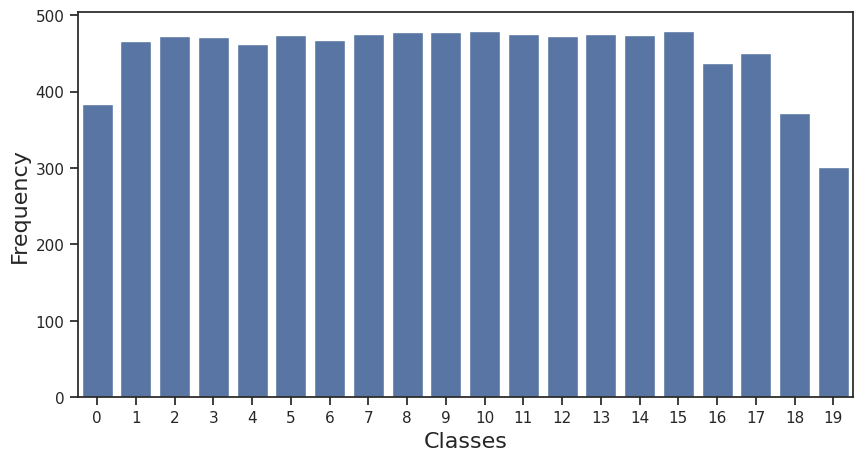

In [ ]:
class_counts = Counter(Y_train.tolist())
class_counts = [class_counts[class_index] for class_index in range(num_classes)]
plt.figure(figsize=(10, 5))
sns.barplot(x=np.arange(num_classes), y=class_counts)
plt.xlabel("Classes", fontsize=16)
plt.ylabel("Frequency", fontsize=16)

## Define the embedding and positional encoding layers

In [ ]:
class EmbeddingLayer(torch.nn.Module):
    def __init__(self, d_model, vocab_size):
        super(EmbeddingLayer, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.embedding(x) * np.sqrt(self.d_model)


class PositionalEncodingLayer(torch.nn.Module):
    def __init__(self, d_model, seq_len, dropout):
        super(PositionalEncodingLayer, self).__init__()
        # Add dropout if required
        self.dropout = torch.nn.Dropout(p=dropout)
        # Create an embedding of seq_len x d_model.
        # This will be applied across batches
        pe = torch.zeros(seq_len, d_model)
        # Define the numerator
        position = torch.arange(0, seq_len).unsqueeze(1)
        # Define the denominator
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(torch.math.log(10000.0) / d_model))
        # start_pos:en_pos:skip = 0::2
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        # Do not register pe as a parameter hence no grad calculations
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)]
        return self.dropout(x)

## Define the multi-head attention layer

In [ ]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_model, num_heads, dropout):
        super(MultiHeadAttention, self).__init__()
        # Make sure that the embedding dimension is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.dropout = dropout
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        # Define the attention projection layers
        self.W_q = torch.nn.Linear(d_model, d_model)
        self.W_k = torch.nn.Linear(d_model, d_model)
        self.W_v = torch.nn.Linear(d_model, d_model)
        self.W_o = torch.nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Perform scaled attention
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        if mask is not None:
            # Wherever the mask is 0, replace the values with -1e9
            # This ensures that e^(-1e9)=0 when computing softmax
            mask = mask.squeeze()
            mask = mask.view(mask.shape[0], 1, 1, mask.shape[1])
            attn_scores = attn_scores.masked_fill(mask != 0, -1e9)
        # Compute softmax to generate the attention scores
        attn_probs = torch.softmax(attn_scores, dim=-1)
        # Multiply the attention scores back Value
        output = torch.matmul(attn_probs, V)
        return output, attn_probs

    # This function splits the output into different heads
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        # The view function performs efficient reshaping without making a copy
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    # This function combines the output from each attention head
    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        # performing transpose leads to different slices of the same tensor
        # to be in different memory locations. For efficient reshapeing with view,
        # the tensor must exist in the same memory location.
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        # Perform a forward pass through the linear layer
        # Then split into heads to compute attention scores separately
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        # Apply self-attention
        attn_output, attn_wts = self.scaled_dot_product_attention(Q, K, V, mask)
        # Final projection
        output = self.W_o(self.combine_heads(attn_output))
        return output, attn_wts

## Define the Positionwise feed-forward Networks

In [ ]:
class PositionWiseFeedForward(torch.nn.Module):
    def __init__(self, d_model, d_ff, dropout):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = torch.nn.Linear(d_model, d_ff)
        self.fc2 = torch.nn.Linear(d_ff, d_model)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        return self.fc2(self.dropout(torch.nn.ReLU()((self.fc1(x)))))

## Define the Encoder block

In [ ]:
class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff, dropout)
        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, mask):
        # Get output from multi-head attention layer
        attn_output, _ = self.self_attn(x, x, x, mask)
        # Add skip connection and then normalize
        x = self.norm1(x + self.dropout(attn_output))
        # Get output from projection layers
        ff_output = self.feed_forward(x)
        # Add skip connection and then normalize
        x = self.norm2(x + self.dropout(ff_output))
        return x

## Finally, define the transformer model

In [ ]:
class Transformer(torch.nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_enc_layers, d_ff, seq_len, dropout, num_classes):
        super(Transformer, self).__init__()
        # The encoder and decoder embeddings are going to be shared since this is not a translation task
        self.encoder_embedding = self.decoder_embedding = EmbeddingLayer(d_model, vocab_size)
        self.positional_encoding = PositionalEncodingLayer(d_model, seq_len, dropout)
        # Stack encoder and decoder blocks
        self.encoder_layers = torch.nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_enc_layers)])
        # Final classification layer
        self.fc = torch.nn.Linear(d_model, num_classes)
        self.dropout = torch.nn.Dropout(dropout)
        # Define the optimizer
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=0.0003)
        # Define the objective function
        self.criterion = torch.nn.CrossEntropyLoss()

    # Generate masks to make sure that our model does not attend to <pad> tokens
    def generate_mask(self, src):
        src_mask = (src == 0)
        return src_mask

    def forward(self, src):
        # Generate masks for the given sequence
        src_mask = self.generate_mask(src)
        # Get the embeddings
        src_embedded = self.positional_encoding(self.encoder_embedding(src))
        # Get output from the final encoder block
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)
        # Aggregate the final decoder layer output
        output = torch.max(enc_output, dim=1).values
        # Perform classification
        output = self.fc(output)
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        self.optimizer.zero_grad()
        preds = self.forward(x)
        loss = self.criterion(preds, y)
        loss.backward()
        self.optimizer.step()
        return loss.item(), preds.numpy(force=True)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self.forward(x)
        loss = self.criterion(preds, y)
        return loss.item(), preds.numpy(force=True)

## Create the data loaders

In [ ]:
batch_size = 256
num_workers = 2

train_data_loader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(Y_train)), batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_data_loader = DataLoader(TensorDataset(torch.tensor(X_val), torch.tensor(Y_val)), batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_data_loader = DataLoader(TensorDataset(torch.tensor(X_test), torch.tensor(Y_test)), batch_size=batch_size, num_workers=num_workers, shuffle=False)

## Some hyper-parameters

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 100
vocab_size = len(token_to_idx)
d_model = 32
num_heads = 4
num_enc_layers = 4
d_ff = 128
dropout = 0.1

## Perform training and validation using our custom transformer implementation

In [ ]:
model = Transformer(vocab_size, d_model, num_heads, num_enc_layers, d_ff, seq_len, dropout, num_classes)
model.to(device)

train_epoch_loss = list()
val_epoch_loss = list()
min_val_loss = np.inf
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    # Training loop
    train_iter_loss = list()
    model.train()
    for batch_idx, batch in enumerate(train_data_loader):
        batch = (batch[0].to(device), batch[1].to(device))
        loss, _ = model.training_step(batch, batch_idx)
        train_iter_loss.append(loss)
    train_epoch_loss.append(sum(train_iter_loss)/len(train_iter_loss))

    # Validation loop
    val_iter_loss = list()
    model.eval()
    for batch_idx, batch in enumerate(val_data_loader):
        batch = (batch[0].to(device), batch[1].to(device))
        loss, _ = model.validation_step(batch, batch_idx)
        val_iter_loss.append(loss)
    val_epoch_loss.append(sum(val_iter_loss)/len(val_iter_loss))
    if val_epoch_loss[-1] < min_val_loss:
        min_val_loss = val_epoch_loss[-1]
        best_model = deepcopy(model)
    pbar.set_description("train_loss: "+str(train_epoch_loss[-1])+"\tval_loss:"+str(val_epoch_loss[-1]))

train_loss: 0.3126959088775847	val_loss:0.953683873017629: 100%|██████████| 100/100 [05:22<00:00,  3.22s/it]


## Plot the training and validation losses

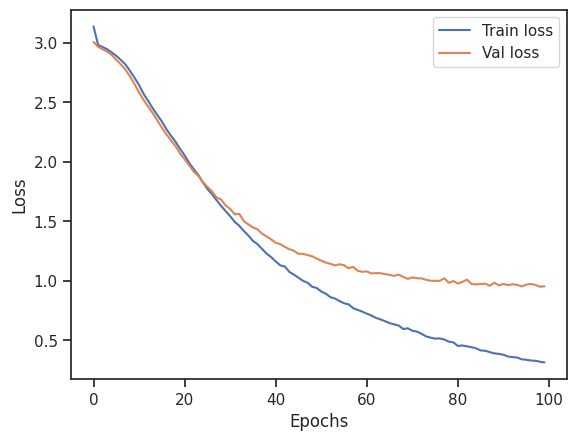

In [ ]:
sns.lineplot(x=np.arange(num_epochs), y=train_epoch_loss, label="Train loss")
sns.lineplot(x=np.arange(num_epochs), y=val_epoch_loss, label="Val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## Get all the predictions on the train and validation set

In [ ]:
train_data_loader_copy = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(Y_train)), batch_size=batch_size, num_workers=num_workers, shuffle=False)
train_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(train_data_loader_copy), total=len(train_data_loader_copy), desc="Predicting on Train set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    train_total_predictions.extend(preds)
train_total_predictions = np.argmax(np.asarray(train_total_predictions), axis=1)
ground_truth = Y_train
print("\nTrain Accuracy:", accuracy_score(train_total_predictions, Y_train))
print("Train Precision:", precision_score(train_total_predictions, ground_truth, average="micro"))
print("Train Confusion Matrix:\n", confusion_matrix(train_total_predictions, ground_truth), "\n\n")

val_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(val_data_loader), total=len(val_data_loader), desc="Predicting on Val set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    val_total_predictions.extend(preds)
val_total_predictions = np.argmax(np.asarray(val_total_predictions), axis=1)
ground_truth = Y_val
print("\nValidation Accuracy:", accuracy_score(val_total_predictions, ground_truth))
print("Validation Precision:", precision_score(val_total_predictions, ground_truth, average="micro"))
print("Validation Confusion Matrix:\n", confusion_matrix(val_total_predictions, ground_truth), "\n\n")

test_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(test_data_loader), total=len(test_data_loader), desc="Predicting on Test set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    test_total_predictions.extend(preds)
test_total_predictions = np.argmax(np.asarray(test_total_predictions), axis=1)
ground_truth = Y_test
print("\nTest Accuracy:", accuracy_score(test_total_predictions, ground_truth))
print("Test Precision:", precision_score(test_total_predictions, ground_truth, average="micro"))
print("Test Confusion Matrix:\n", confusion_matrix(test_total_predictions, ground_truth), "\n\n")


Predicting on Train set: 100%|██████████| 36/36 [00:01<00:00, 30.18it/s]


Train Accuracy: 0.9698375870069605
Train Precision: 0.9698375870069605
Train Confusion Matrix:
 [[374   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   1
    0  24]
 [  0 453   3   2   2   0   0   0   0   0   0   0  12   1   0   0   0   0
    0   0]
 [  0   5 456  11   1   1   0   3   0   0   0   0   8   0   0   0   0   0
    0   0]
 [  0   3   6 438   4   1  16   0   0   0   0   2  13   0   0   0   0   0
    0   0]
 [  0   2   1   8 450   0   1   0   0   0   0   1  12   0   0   0   0   0
    0   0]
 [  0   4   7   2   3 472   0   0   1   0   0   1   2   0   0   0   0   0
    0   0]
 [  0   0   0   9   3   0 444   4   1   0   0   1   3   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   3 455   0   0   0   0   2   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   2 469   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0 478   0   0   0   0   4   0   0   0
    2   1]
 [  0   0   0   0   0   0   1   0   3   0 480   0   0


Predicting on Val set: 100%|██████████| 9/9 [00:00<00:00, 26.96it/s]


Validation Accuracy: 0.755634114007954
Validation Precision: 0.755634114007954
Validation Confusion Matrix:
 [[ 76   0   0   0   0   0   0   3   0   0   0   0   0   1   2  10   4   6
    0  10]
 [  0  81  12  11   9   5   6   5   2   0   0   1  12  10   4   4   0   0
    0   1]
 [  0   5  92   6   1   6   1   2   0   0   0   0   2   0   2   0   0   0
    0   0]
 [  0   8   4  84  12   1   4   2   0   0   0   3   8   0   0   0   0   0
    0   1]
 [  0   5   4   8  75   3   6   2   0   0   0   2   9   3   0   2   0   0
    0   0]
 [  0   7   2   2   3  98   0   1   4   2   0   1   2   1   1   1   0   0
    0   0]
 [  0   4   1   3   3   0  82   3   2   0   0   0   1   0   0   2   2   0
    1   1]
 [  1   0   0   1   0   0   1  86   5   1   0   0   3   1   1   0   1   0
    2   2]
 [  0   1   0   0   0   0   2   2  97   2   0   1   4   0   1   0   1   0
    3   2]
 [  0   0   0   0   1   1   0   1   1 107   2   1   4   0   1   0   0   0
    0   0]
 [  0   1   1   0   2   2   6   0   1   


Predicting on Test set: 100%|██████████| 30/30 [00:00<00:00, 31.34it/s]


Test Accuracy: 0.6267923526287839
Test Precision: 0.6267923526287839
Test Confusion Matrix:
 [[155   0   0   0   0   0   0   3   2   4   1   2   0   6   4  28  10  44
   10  37]
 [  6 258  49  55  16  71  16  21   5   7  10   8  61  66  17   8   6   5
    5   5]
 [  0  16 233  27  12  59   2   5   3   2   2   1  18   1   6   1   0   0
    0   0]
 [  1  16  29 231  20  11  24   5   0   1   1  11  27   1   2   0   0   0
    1   0]
 [  0  18  27  20 268   9  11   0   1   0   0  12  33   6   2   1   2   2
    1   1]
 [  1  21  21  14  15 207   2   1  11  16   2   3  18   4  11   2   0   0
    1   0]
 [  1   6   1  16  12   6 298  17   8   4   6   9  12   1   3   8   4   0
    2   2]
 [  0   1   1   1   0   1   5 260  16   1   0   2  14   3   3   3   6   0
    4   3]
 [  3   2   4   0   2   3   1  14 303   8   5   1   4   9   5   4   3   1
    6   9]
 [  1   1   1   1   1   3   2   3   4 251  10   6   7   6   9   0   2   5
    7   2]
 [  2   4   1   5   3   1   9   2   4  69 339   3   7  1

## Replace custom Multi Head Attention Layer with PyTorch Multi Head Attention and perform training and validation

In [ ]:
model = Transformer(vocab_size, d_model, num_heads, num_enc_layers, d_ff, seq_len, dropout, num_classes)
# Replace the multi-head attention layers with Pytorch version
for i in range(num_enc_layers):
    model.encoder_layers[i].self_attn = torch.nn.MultiheadAttention(d_model, num_heads, dropout, batch_first=True)
model.to(device)

train_epoch_loss = list()
val_epoch_loss = list()
min_val_loss = np.inf
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    # Training loop
    train_iter_loss = list()
    model.train()
    for batch_idx, batch in enumerate(train_data_loader):
        batch = (batch[0].to(device), batch[1].to(device))
        loss, _ = model.training_step(batch, batch_idx)
        train_iter_loss.append(loss)
    train_epoch_loss.append(sum(train_iter_loss)/len(train_iter_loss))

    # Validation loop
    val_iter_loss = list()
    model.eval()
    for batch_idx, batch in enumerate(val_data_loader):
        batch = (batch[0].to(device), batch[1].to(device))
        loss, _ = model.validation_step(batch, batch_idx)
        val_iter_loss.append(loss)
    val_epoch_loss.append(sum(val_iter_loss)/len(val_iter_loss))
    if val_epoch_loss[-1] < min_val_loss:
        min_val_loss = val_epoch_loss[-1]
        best_model = deepcopy(model)
    pbar.set_description("train_loss: "+str(train_epoch_loss[-1])+"\tval_loss:"+str(val_epoch_loss[-1]))

train_loss: 1.2510677774747212	val_loss:1.4450509680642023: 100%|██████████| 100/100 [05:11<00:00,  3.12s/it]


## Plot the training and validation losses

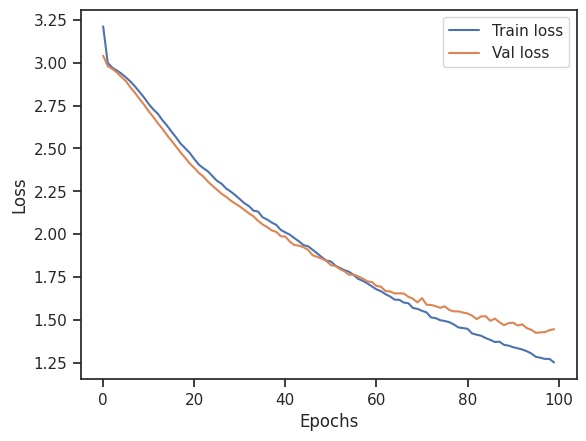

In [ ]:
sns.lineplot(x=np.arange(num_epochs), y=train_epoch_loss, label="Train loss")
sns.lineplot(x=np.arange(num_epochs), y=val_epoch_loss, label="Val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## Get all the predictions on the train and validation set

In [ ]:
train_data_loader_copy = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(Y_train)), batch_size=batch_size, num_workers=num_workers, shuffle=False)
train_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(train_data_loader_copy), total=len(train_data_loader_copy), desc="Predicting on Train set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    train_total_predictions.extend(preds)
train_total_predictions = np.argmax(np.asarray(train_total_predictions), axis=1)
ground_truth = Y_train
print("\nTrain Accuracy:", accuracy_score(train_total_predictions, ground_truth))
print("Train Precision:", precision_score(train_total_predictions, ground_truth, average="micro"))
print("Train Confusion Matrix:\n", confusion_matrix(train_total_predictions, ground_truth), "\n\n")

val_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(val_data_loader), total=len(val_data_loader), desc="Predicting on Val set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    val_total_predictions.extend(preds)
val_total_predictions = np.argmax(np.asarray(val_total_predictions), axis=1)
ground_truth = Y_val
print("\nValidation Accuracy:", accuracy_score(val_total_predictions, ground_truth))
print("Validation Precision:", precision_score(val_total_predictions, ground_truth, average="micro"))
print("Validation Confusion Matrix:\n", confusion_matrix(val_total_predictions, ground_truth), "\n\n")

test_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(test_data_loader), total=len(test_data_loader), desc="Predicting on Test set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    test_total_predictions.extend(preds)
test_total_predictions = np.argmax(np.asarray(test_total_predictions), axis=1)
ground_truth = Y_test
print("\nTest Accuracy:", accuracy_score(test_total_predictions, ground_truth))
print("Test Precision:", precision_score(test_total_predictions, ground_truth, average="micro"))
print("Test Confusion Matrix:\n", confusion_matrix(test_total_predictions, ground_truth), "\n\n")


Predicting on Train set: 100%|██████████| 36/36 [00:01<00:00, 30.83it/s]


Train Accuracy: 0.7005855706551762
Train Precision: 0.7005855706551762
Train Confusion Matrix:
 [[280   1   0   2   0   0   0   7   9   0   3   4   2   1   4  42   6  13
   28  62]
 [  0 217  23  40  31  16  11   5   8   5   2   3  38  12   9   1   1   1
    1   1]
 [  0  40 333  47   5  49  11   6   0   0   0   5   6   1   2   0   1   0
    0   1]
 [  0  67  46 267  43  19  32   7   5   3   1   1  46   7   3   1   0   0
    2   2]
 [  0  16   2  18 309   3  12   0   6   1   1   3  35   2   1   0   0   0
    0   0]
 [  0  93  44  52  22 374  22   4   6   6   2   6  40   2   3   1   0   0
    1   0]
 [  0   1   2  12  11   1 317   6  11   5   0   0  12   6   1   0   4   1
    0   0]
 [  5   1   1   3   2   1  14 340  16   4   1   2  21   8   2   3   4   2
    2   5]
 [  4   0   4   3  12   3   2  21 357   1   4   2   6  21   4   9   5   0
    4   1]
 [  1   5   4   9   6   3   5  22   9 405  17   1  20  13  17   6   5   0
   13   2]
 [  2   0   0   0   1   0   2   3   3  10 422   2   1


Predicting on Val set: 100%|██████████| 9/9 [00:00<00:00, 31.43it/s]


Validation Accuracy: 0.5695978789217853
Validation Precision: 0.5695978789217853
Validation Confusion Matrix:
 [[65  0  0  0  0  0  0  1  3  2  0  1  1  3  2 12  0  6 11 12]
 [ 0 33  6  8  7  6  7  2  0  2  1  2  7  8  7  3  2  1  1  1]
 [ 0 10 77 11  0 13  1  0  0  0  0  3  1  1  0  0  1  0  0  0]
 [ 2 13 12 51 20  7 10  3  0  0  1  3 12  1  5  2  0  0  1  1]
 [ 0  4  2  9 52  0  3  0  1  1  2  0 11  3  0  1  0  1  0  1]
 [ 1 40 11 20 13 86 11  3  4  4  1  1 16  2  4  1  1  1  0  0]
 [ 0  3  1  2  2  0 68  3  3  0  1  0  2  2  0  0  1  1  1  0]
 [ 1  1  1  1  0  1  3 79 12  0  2  0  8  4  0  0  1  0  3  1]
 [ 2  2  2  1  5  1  0  9 67  3  0  1  3  6  4  2  5  0  0  1]
 [ 2  2  1  3  3  1  5  4  6 91 10  2  6  6  5  2  0  2  5  3]
 [ 0  0  0  0  1  1  1  0  0  5 94  0  1  2  5  1  1  2  4  0]
 [ 0  1  0  2  0  2  0  0  1  1  1 88  3  0  3  0  2  1  4  2]
 [ 0  4  3  3  6  0  4  4  5  1  0  0 36  1  5  4  2  0  1  0]
 [ 2  2  1  3  1  0  1  2  5  1  2  2  2 59  1  4  3  4  2  2]
 [ 1  


Predicting on Test set: 100%|██████████| 30/30 [00:00<00:00, 36.06it/s]


Test Accuracy: 0.5134094530005311
Test Precision: 0.5134094530005311
Test Confusion Matrix:
 [[141   1   2   0   0   0   1   2   8   5   4   2   2  14  16  46  12  57
   16  45]
 [ 11 120  21  30  31  21  14  23  12   7   5  13  36  53  25   4   6   7
    7   4]
 [  1  25 232  47   9  77  12   2   2   2   0   8  15   2   1   2   2   0
    0   2]
 [  1  40  35 178  47  31  26   6   4   5   2   7  47  15  18   6   1   1
    5   3]
 [  2  12  16  26 205   3  16   0   5   5   2   6  26  10   6   3   1   1
    0   3]
 [  4 118  49  58  28 232  36  17   8  14   8  10  60  18   9   6   4   3
    4   2]
 [  1   4   1   5   8   2 242  19  15   7   3   5  11  10   5   1   4   1
    0   1]
 [  2   4   4   1   2   3   6 243  18   9   0   5  15   8   9   2   8   3
    4   5]
 [  5   5   6   0  15   1   4  15 245   8   7   3   8  16   7   9  10  10
    7   2]
 [  8   7   5   5   5   3  11  10  15 270  34  11  22  20   5  15   7   6
   14   7]
 [  6   1   1   0   1   0   0   3   5  19 277   0   4   

## Define the Pytorch Transformer model

In [ ]:
class Transformer(torch.nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, seq_len, dropout, num_classes):
        super(Transformer, self).__init__()
        # The encoder and decoder embeddings are going to be shared since this is not a translation task
        self.encoder_embedding = self.decoder_embedding = EmbeddingLayer(d_model, vocab_size)
        self.positional_encoding = PositionalEncodingLayer(d_model, seq_len, dropout)
        encoder_layer = torch.nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=d_ff, dropout=dropout, batch_first=True)
        self.backbone = torch.nn.TransformerEncoder(encoder_layer, num_layers, norm=torch.nn.LayerNorm(d_model), enable_nested_tensor=True, mask_check=True)
        # Final classification layer
        self.fc = torch.nn.Linear(d_model, num_classes)
        self.dropout = torch.nn.Dropout(dropout)
        # Define the optimizer
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=0.0003)
        # Define the objective function
        self.criterion = torch.nn.CrossEntropyLoss()

    # Generate masks to make sure that our model does not attend to <pad> tokens
    def generate_mask(self, src):
        src_mask = (src == 0)
        return src_mask

    def forward(self, src):
        # Generate masks for the given sequence
        src_mask = self.generate_mask(src)
        # Get the embeddings
        src_embedded = self.positional_encoding(self.encoder_embedding(src))
        output = self.backbone(src_embedded, src_key_padding_mask=src_mask)
        # Aggregate the final decoder layer output
        output = torch.max(output, dim=1).values
        # Perform classification
        output = self.fc(output)
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        self.optimizer.zero_grad()
        preds = self.forward(x)
        loss = self.criterion(preds, y)
        loss.backward()
        self.optimizer.step()
        return loss.item(), preds.numpy(force=True)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self.forward(x)
        loss = self.criterion(preds, y)
        return loss.item(), preds.numpy(force=True)

## Perform training and validation using the PyTorch transformer

In [ ]:
model = Transformer(vocab_size, d_model, num_heads, num_enc_layers, d_ff, seq_len, dropout, num_classes)
model.to(device)

train_epoch_loss = list()
val_epoch_loss = list()
min_val_loss = np.inf
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    # Training loop
    train_iter_loss = list()
    model.train()
    for batch_idx, batch in enumerate(train_data_loader):
        batch = (batch[0].to(device), batch[1].to(device))
        loss, _ = model.training_step(batch, batch_idx)
        train_iter_loss.append(loss)
    train_epoch_loss.append(sum(train_iter_loss)/len(train_iter_loss))

    # Validation loop
    val_iter_loss = list()
    model.eval()
    for batch_idx, batch in enumerate(val_data_loader):
        batch = (batch[0].to(device), batch[1].to(device))
        loss, _ = model.validation_step(batch, batch_idx)
        val_iter_loss.append(loss)
    val_epoch_loss.append(sum(val_iter_loss)/len(val_iter_loss))
    if val_epoch_loss[-1] < min_val_loss:
        min_val_loss = val_epoch_loss[-1]
        best_model = deepcopy(model)
    pbar.set_description("train_loss: "+str(train_epoch_loss[-1])+"\tval_loss:"+str(val_epoch_loss[-1]))

train_loss: 0.43464387042654884	val_loss:1.443366249402364: 100%|██████████| 100/100 [04:44<00:00,  2.85s/it]


## Plot the training and validation losses

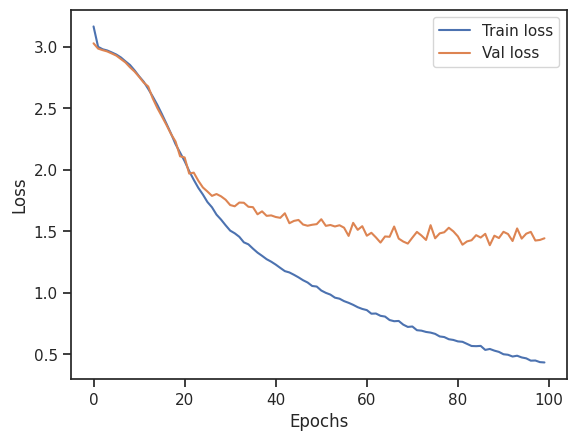

In [ ]:
sns.lineplot(x=np.arange(num_epochs), y=train_epoch_loss, label="Train loss")
sns.lineplot(x=np.arange(num_epochs), y=val_epoch_loss, label="Val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## Get all the predictions on the train and validation set

In [ ]:
train_data_loader_copy = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(Y_train)), batch_size=batch_size, num_workers=num_workers, shuffle=False)
train_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(train_data_loader_copy), total=len(train_data_loader_copy), desc="Predicting on Train set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    train_total_predictions.extend(preds)
train_total_predictions = np.argmax(np.asarray(train_total_predictions), axis=1)
ground_truth = Y_train
print("\nTrain Accuracy:", accuracy_score(train_total_predictions, ground_truth))
print("Train Precision:", precision_score(train_total_predictions, ground_truth, average="micro"))
print("Train Confusion Matrix:\n", confusion_matrix(train_total_predictions, ground_truth), "\n\n")

val_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(val_data_loader), total=len(val_data_loader), desc="Predicting on Val set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    val_total_predictions.extend(preds)
val_total_predictions = np.argmax(np.asarray(val_total_predictions), axis=1)
ground_truth = Y_val
print("\nValidation Accuracy:", accuracy_score(val_total_predictions, ground_truth))
print("Validation Precision:", precision_score(val_total_predictions, ground_truth, average="micro"))
print("Validation Confusion Matrix:\n", confusion_matrix(val_total_predictions, ground_truth), "\n\n")

test_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(test_data_loader), total=len(test_data_loader), desc="Predicting on Test set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    test_total_predictions.extend(preds)
test_total_predictions = np.argmax(np.asarray(test_total_predictions), axis=1)
ground_truth = Y_test
print("\nTest Accuracy:", accuracy_score(test_total_predictions, ground_truth))
print("Test Precision:", precision_score(test_total_predictions, ground_truth, average="micro"))
print("Test Confusion Matrix:\n", confusion_matrix(test_total_predictions, ground_truth), "\n\n")


Predicting on Train set: 100%|██████████| 36/36 [00:00<00:00, 42.78it/s]


Train Accuracy: 0.905645784996133
Train Precision: 0.905645784996133
Train Confusion Matrix:
 [[354   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   3   2
    6  10]
 [  0 442  19  11   6  19   1   2   0   1   2   0  10   2   0   2   0   0
    0   1]
 [  0  14 436  14  10   4   2   0   1   0   0   0   1   1   1   0   0   0
    0   0]
 [  0   2   9 432  65   1  25   3   0   0   0   0  62   0   0   0   0   0
    0   0]
 [  0   1   3   9 373   0   5   5   1   0   0   1  60   1   1   0   0   0
    1   0]
 [  0   7   6   0   0 450   1   1   0   0   4   2   1   0   1   0   0   0
    0   0]
 [  0   0   0   3   6   0 412  10   3   0   0   0  10   1   0   0   0   1
    0   0]
 [  0   0   0   0   1   0   6 390   7   1   0   0  10   1   0   0   1   0
    0   0]
 [  2   0   0   1   0   0   4  44 463   0   0   0   1   4   0   0   0   0
    3   0]
 [  0   0   0   0   0   0   0   3   0 463   5   2   1   8   0   0   2   0
    5   0]
 [  0   1   0   0   0   0   1   0   0   9 466   0   1  


Predicting on Val set: 100%|██████████| 9/9 [00:00<00:00, 38.00it/s]


Validation Accuracy: 0.6469288555015467
Validation Precision: 0.6469288555015467
Validation Confusion Matrix:
 [[ 70   0   0   1   1   0   0   0   0   1   0   1   1   0   1   1   4   4
    2   4]
 [  0  57  11  15   5   4   0   0   0   1   2   0   3   3   2   1   0   0
    0   1]
 [  0   2  57   2   1   2   0   0   1   0   0   0   1   0   0   0   0   0
    0   0]
 [  0   8  12  59  15   0   5   2   0   0   0   0  15   0   1   0   1   1
    0   0]
 [  0   0   4   9  49   0   1   1   0   0   0   0   3   0   1   0   0   0
    0   0]
 [  0  12  12   1   1  81   0   0   0   0   2   1   2   0   2   0   0   0
    0   0]
 [  0   5   1   6   4   1  83   5   3   0   0   0   7   0   0   0   2   0
    2   0]
 [  1   0   0   1   0   0   0  78   8   0   0   0   5   0   0   0   1   1
    1   1]
 [  0   0   2   0   2   0   2   6  89   0   0   0   3   2   1   0   1   0
    0   0]
 [  1   9   6   5  13  15  14   8   8 106  10  11  13  29   4   5   6   2
   19   4]
 [  6  22   7  10  12  15   5   1   0 


Predicting on Test set: 100%|██████████| 30/30 [00:00<00:00, 48.05it/s]


Test Accuracy: 0.5249601699415826
Test Precision: 0.5249601699415826
Test Confusion Matrix:
 [[130   0   0   0   2   0   0   1   0   0   0   3   0   4   4  12  16  15
    7  18]
 [  0 133  57  57  22  34   2   1   0   5   3   0  28   2   4   2   2   0
    1   1]
 [  0   8 106  12   4   6   1   3   1   0   0   0   5   1   0   1   0   0
    0   0]
 [  0  15  48 184  36   5  13   3   0   0   0   2  25   0   0   1   0   0
    0   0]
 [  1   3   9  16 149   0   7   2   0   1   0   2  14   1   2   0   0   0
    0   0]
 [  1  31  65   3   2 198   1   0   0   2   2  13   3   0   1   0   0   0
    0   0]
 [  0   2   2  23  14   3 272  11   6   2   0   0  15   1   3   0   3   0
    1   0]
 [  0   0   1   3   4   0   7 204  20   1   0   3  12   3   0   0   1   0
    5   1]
 [  0   1   5   0   1   0   2  12 284   1   0   2   6   1   3   0   1   1
    2   1]
 [ 19  53  38  33  57  60  48  75  48 332  38  46  77 167  44   8  56  27
   66  21]
 [ 22 119  37  29  41  84  11   8   7  39 347  20  56  6